# 1. Load Dataset

In [3]:
# https://www.geeksforgeeks.org/how-to-read-all-csv-files-in-a-folder-in-pandas/
# https://stackoverflow.com/questions/8369219/how-can-i-read-a-text-file-into-a-string-variable-and-strip-newlines
# https://stackoverflow.com/questions/10715965/create-a-pandas-dataframe-by-appending-one-row-at-a-time/10716007#10716007

import pandas as pd
import os
import glob

# use glob to get all the txt files in the folder 
path = os.getcwd() + '\\Datasets'
# added -plain to avoid the text description
text_files = glob.glob(os.path.join(path, "*-plain.txt"))

In [4]:
def append_row(df, row):
    return pd.concat([
                df, 
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

df = pd.DataFrame(columns=('lib', 'qty1', 'qty2'))




In [5]:
# Declare a dataframe
df = pd.DataFrame(columns=['Station', 'Text'])

for file in text_files:
    # Get the radio station
    radio_station = file.split('\\Datasets\\')[1].split('-plain.txt')[0][:-1]

    # Get the text data
    with open(file, 'r') as f:
        text = f.read().replace('\n', ' ')

    # Declare a new row to append
    new_row = pd.Series({
        'Station':radio_station,
        'Text':text,
    })

    # Save text into dataframe
    df = append_row(df, new_row)

In [6]:
# Verify correct loading of data
df.head(10)

,Station,Text
0,ABCE,Thanks for that John Hall now John Hall will ...
1,ABCE,Ah look l Les Pete. . Simon. G'day Peto. S...
2,ABCE,If you haven't been with us before this how i...
3,ABCE,Uh blue-tongues'd be unlikely to eat them be...
4,ABCNE,A very good afternoon to you Roly. Good afte...
5,ABCNE,And Greg Kerrin is my guest. Hello Greg. G'd...
6,COME,Good morning and welcome to another Two G B w...
7,COME,Good morning everyone and welcome to a very f...
8,COME,The doctor is in the lines are open one-three...
9,COME,Morning Mark. Uh uh good morning John. Um t...


In [7]:
# Some notes...
# Already can see some australian slang - G'day appears in a few text files already
# Much more casual language sometimes
# Data is unbalanced - some stations more represented than others - how to deal with it?


# 2. Preprocessing
Goals
- Find the most common word used in the text to find topic
    - May have to use bigrams or trigrams if a topic is something like "solar energy" or "nuclear waste"
    - decisions will be made after this test
- Current pipeline
    - remove punctuation
    - remove numerics
    - all text to lowercase
    - remove stopwords
    - remove extra whitespace

In [9]:
# Taken from week 2 lab
# We create a TextPreprocessor class that encapsulates all the preprocessing steps. The class constructor allows for custom punctuation marks and stopwords to be added.
# Each preprocessing step is implemented as a separate method so we can define in which order they need to be called.

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string

# Download necessary NLTK data - already downloaded, commented to clean output a bit
#nltk.download('punkt')
#nltk.download('stopwords')

class TextPreprocessor:
    def __init__(self, custom_punctuation=None, custom_stopwords=None):
        self.punctuation = string.punctuation
        if custom_punctuation:
            self.punctuation += custom_punctuation

        self.stop_words = set(stopwords.words('english'))
        if custom_stopwords:
            self.stop_words.update(custom_stopwords)

        self.stemmer = PorterStemmer()

    def remove_punctuation(self, text):
        return ''.join([char for char in text if char not in self.punctuation])

    # Custom one for the CNN dataset - try removing below and see results
    def add_space_after_parenthesis(self, text):
        return re.sub(r'\)', ') ', text)

    def to_lowercase(self, text):
        return text.lower()

    def remove_stopwords(self, text):
        words = word_tokenize(text)
        return ' '.join([word for word in words if word not in self.stop_words])

    def remove_extra_whitespace(self, text): # This is to remove our CNN) problem - The space is added before punctuation removal, so it won't affect the final preprocessed text if you're removing all punctuation
        return re.sub(r'\s+', ' ', text).strip()

    def stem_words(self, text):
        words = word_tokenize(text)
        return ' '.join([self.stemmer.stem(word) for word in words])

    # Drop the first character(is a 0) and any \n<numeric>
    def remove_numerics(self, text):
        return re.sub('\d*', '', text[1:])

    #Order matters - how you call these methods is how the text will be processed step-by-step
    # rearrange if we want to change the order of functions here
    def preprocess(self, text):
        text = self.remove_punctuation(text)
        text = self.remove_numerics(text)
        text = self.to_lowercase(text)
        text = self.remove_stopwords(text)
        #text = self.remove_extra_whitespace(text)
        #text = self.add_space_after_parenthesis(text)
        #text = self.stem_words(text)
        return text

In [10]:
preprocessor = TextPreprocessor()
text_cleaned = preprocessor.preprocess(df.Text[0])

In [11]:
text_cleaned[:500]

'thanks john hall john hall listening next hour cos angus stewart take calls eighttriplethreeonethousand oneeighthundredeighthundredsevenohtwo something garden thats causing problems give us call right angus mean yknow known trade mr popergation mr propagation hes also known passion natives love orchids right far guess yeah yeah hes also known ability open cosposting toilets tell anything worm farm problems certainly helped us although im still confused dry ingredients might talk well eighttriple'

In [12]:
df.Text[0][:500]

" Thanks for that John Hall now John Hall will be listening for the next hour 'cos Angus Stewart is here to take your calls eight-triple-three-one-thousand one-eight-hundred-eight-hundred-seven-oh-two something in the garden that's causing you problems give us a call right now and Angus can I mean y'know he is known in the trade as Mr popergation  Mr propagation. He's also known for his passion for natives and his love of o orchids am I right so far.  I guess yeah yeah .  He's also known  for his"

- hyphens may need to be turned into spaces
- 'cos --> because (slang)??? for now leave as is

In [14]:
# Redefine with a step to change hyphen to spaces
# Code cleaned up
class TextPreprocessor:
    def __init__(self, custom_punctuation=None, custom_stopwords=None):
        self.punctuation = string.punctuation
        if custom_punctuation:
            self.punctuation += custom_punctuation

        self.stop_words = set(stopwords.words('english'))
        if custom_stopwords:
            self.stop_words.update(custom_stopwords)

        self.stemmer = PorterStemmer()

    def remove_punctuation(self, text):
        return ''.join([char for char in text if char not in self.punctuation])

    def to_lowercase(self, text):
        return text.lower()

    def remove_stopwords(self, text):
        words = word_tokenize(text)
        return ' '.join([word for word in words if word not in self.stop_words])

    # Drop the first character(is a 0) and any \n<numeric>
    def remove_numerics(self, text):
        return re.sub('\d*', '', text[1:])

    # Change hypen to space
    def hyphen_to_space(self, text):
        return text.replace('-', ' ')
    
    def preprocess(self, text):
        text = self.hyphen_to_space(text)
        text = self.remove_punctuation(text)
        text = self.remove_numerics(text)
        text = self.to_lowercase(text)
        text = self.remove_stopwords(text)
        return text

In [15]:
preprocessor = TextPreprocessor()
text_cleaned = preprocessor.preprocess(df.Text[0])

In [16]:
text_cleaned[:500]

'thanks john hall john hall listening next hour cos angus stewart take calls eight triple three one thousand one eight hundred eight hundred seven oh two something garden thats causing problems give us call right angus mean yknow known trade mr popergation mr propagation hes also known passion natives love orchids right far guess yeah yeah hes also known ability open cosposting toilets tell anything worm farm problems certainly helped us although im still confused dry ingredients might talk well '

In [17]:
processed_text = []

# Add cleaned text to dataframe for later use
for index, row in df.iterrows():
    processed_text.append(preprocessor.preprocess(row.Text))

# Add new column
df.insert(2, "Text_Clean", processed_text)

In [18]:
df.head(10)

,Station,Text,Text_Clean
0,ABCE,Thanks for that John Hall now John Hall will ...,thanks john hall john hall listening next hour...
1,ABCE,Ah look l Les Pete. . Simon. G'day Peto. S...,ah look l les pete simon gday peto simo gday l...
2,ABCE,If you haven't been with us before this how i...,havent us functions jurate sasnaitis joins us ...
3,ABCE,Uh blue-tongues'd be unlikely to eat them be...,uh blue tonguesd unlikely eat good old uh hemi...
4,ABCNE,A very good afternoon to you Roly. Good afte...,good afternoon roly good afternoon sir mm good...
5,ABCNE,And Greg Kerrin is my guest. Hello Greg. G'd...,greg kerrin guest hello greg gday trevor well ...
6,COME,Good morning and welcome to another Two G B w...,good morning welcome another two g b weekend o...
7,COME,Good morning everyone and welcome to a very f...,good morning everyone welcome foggy sort overc...
8,COME,The doctor is in the lines are open one-three...,doctor lines open one three one eight seven th...
9,COME,Morning Mark. Uh uh good morning John. Um t...,morning mark uh uh good morning john um yeah i...


In [19]:
# Lets try to find the word count

def word_count(text):
    wc = len(text.split())
    return wc

In [20]:
df['Text_Word_Count'] = df.Text_Clean.apply(word_count)

In [21]:
df

# Not sure if useful, but some texts are longer than others

# ABCNE seems to be much shorter than the others
# NAT tends to be longer, with 2 very long texts
# COME has a very long text, but also a few very short texts

,Station,Text,Text_Clean,Text_Word_Count
0,ABCE,Thanks for that John Hall now John Hall will ...,thanks john hall john hall listening next hour...,4970
1,ABCE,Ah look l Les Pete. . Simon. G'day Peto. S...,ah look l les pete simon gday peto simo gday l...,5422
2,ABCE,If you haven't been with us before this how i...,havent us functions jurate sasnaitis joins us ...,3200
3,ABCE,Uh blue-tongues'd be unlikely to eat them be...,uh blue tonguesd unlikely eat good old uh hemi...,1889
4,ABCNE,A very good afternoon to you Roly. Good afte...,good afternoon roly good afternoon sir mm good...,2560
5,ABCNE,And Greg Kerrin is my guest. Hello Greg. G'd...,greg kerrin guest hello greg gday trevor well ...,2371
6,COME,Good morning and welcome to another Two G B w...,good morning welcome another two g b weekend o...,8072
7,COME,Good morning everyone and welcome to a very f...,good morning everyone welcome foggy sort overc...,3953
8,COME,The doctor is in the lines are open one-three...,doctor lines open one three one eight seven th...,6397
9,COME,Morning Mark. Uh uh good morning John. Um t...,morning mark uh uh good morning john um yeah i...,6965


In [22]:
# Find most common word
from collections import Counter

most_common_word = []
most_common_word_count = []

for index, row in df.iterrows():
    text = row.Text_Clean.split()
    word_counter = Counter(text)
    most_common_word.append(word_counter.most_common()[0])

# Add new column
df.insert(4, "Most_Common_Word", most_common_word)

In [23]:
df.head(10)

,Station,Text,Text_Clean,Text_Word_Count,Most_Common_Word
0,ABCE,Thanks for that John Hall now John Hall will ...,thanks john hall john hall listening next hour...,4970,"(uh, 316)"
1,ABCE,Ah look l Les Pete. . Simon. G'day Peto. S...,ah look l les pete simon gday peto simo gday l...,5422,"(uh, 182)"
2,ABCE,If you haven't been with us before this how i...,havent us functions jurate sasnaitis joins us ...,3200,"(um, 61)"
3,ABCE,Uh blue-tongues'd be unlikely to eat them be...,uh blue tonguesd unlikely eat good old uh hemi...,1889,"(um, 52)"
4,ABCNE,A very good afternoon to you Roly. Good afte...,good afternoon roly good afternoon sir mm good...,2560,"(uh, 89)"
5,ABCNE,And Greg Kerrin is my guest. Hello Greg. G'd...,greg kerrin guest hello greg gday trevor well ...,2371,"(uh, 90)"
6,COME,Good morning and welcome to another Two G B w...,good morning welcome another two g b weekend o...,8072,"(uh, 342)"
7,COME,Good morning everyone and welcome to a very f...,good morning everyone welcome foggy sort overc...,3953,"(uh, 121)"
8,COME,The doctor is in the lines are open one-three...,doctor lines open one three one eight seven th...,6397,"(uh, 168)"
9,COME,Morning Mark. Uh uh good morning John. Um t...,morning mark uh uh good morning john um yeah i...,6965,"(uh, 280)"


In [24]:
#uh.... Not a great most common word, thought it would be removed by stopwords

# Remove um, uh

In [25]:
def remove_um_uh(text):
    text_clean = text.replace('um', '')
    text_clean = text_clean.replace('uh', '')
    return text_clean

In [26]:
# Remove the columns created before
df = df.drop('Text_Word_Count', axis=1)
df = df.drop('Most_Common_Word', axis=1)

In [27]:
df['Text_Clean'] = df.Text_Clean.apply(remove_um_uh)

In [28]:
df['Text_Word_Count'] = df.Text_Clean.apply(word_count)

In [29]:
most_common_word = []

for index, row in df.iterrows():
    text = row['Text_Clean'].split()
    word_count = Counter(text)
    most_common_word.append(word_count.most_common()[0])

df.insert(4, "Most_Common_Word", most_common_word)

In [30]:
df.head(10)

,Station,Text,Text_Clean,Text_Word_Count,Most_Common_Word
0,ABCE,Thanks for that John Hall now John Hall will ...,thanks john hall john hall listening next hour...,4571,"(well, 93)"
1,ABCE,Ah look l Les Pete. . Simon. G'day Peto. S...,ah look l les pete simon gday peto simo gday l...,5145,"(yeah, 89)"
2,ABCE,If you haven't been with us before this how i...,havent us functions jurate sasnaitis joins us ...,3100,"(think, 61)"
3,ABCE,Uh blue-tongues'd be unlikely to eat them be...,blue tonguesd unlikely eat good old hemidact...,1794,"(yeah, 42)"
4,ABCNE,A very good afternoon to you Roly. Good afte...,good afternoon roly good afternoon sir mm good...,2433,"(one, 33)"
5,ABCNE,And Greg Kerrin is my guest. Hello Greg. G'd...,greg kerrin guest hello greg gday trevor well ...,2250,"(okay, 32)"
6,COME,Good morning and welcome to another Two G B w...,good morning welcome another two g b weekend o...,7489,"(good, 108)"
7,COME,Good morning everyone and welcome to a very f...,good morning everyone welcome foggy sort overc...,3785,"(well, 74)"
8,COME,The doctor is in the lines are open one-three...,doctor lines open one three one eight seven th...,6121,"(got, 79)"
9,COME,Morning Mark. Uh uh good morning John. Um t...,morning mark good morning john yeah ive ive...,6592,"(well, 157)"


In [62]:
# Examine only first text
text = df['Text_Clean'][0].split()
word_count = Counter(text)
word_count.most_common()[:100]

[('well', 93),
 ('yes', 64),
 ('yeah', 62),
 ('theyre', 54),
 ('like', 48),
 ('thats', 47),
 ('sort', 47),
 ('got', 43),
 ('get', 43),
 ('good', 39),
 ('would', 38),
 ('one', 34),
 ('think', 31),
 ('oh', 30),
 ('garden', 28),
 ('ive', 26),
 ('go', 25),
 ('plants', 25),
 ('bit', 23),
 ('c', 23),
 ('right', 22),
 ('two', 21),
 ('see', 21),
 ('yep', 21),
 ('okay', 20),
 ('seed', 20),
 ('dont', 20),
 ('plant', 19),
 ('could', 19),
 ('seven', 18),
 ('im', 18),
 ('little', 18),
 ('youve', 18),
 ('know', 18),
 ('id', 17),
 ('look', 17),
 ('angus', 16),
 ('three', 16),
 ('something', 16),
 ('also', 16),
 ('open', 16),
 ('time', 16),
 ('really', 16),
 ('mm', 16),
 ('thank', 15),
 ('actually', 15),
 ('put', 15),
 ('grow', 15),
 ('theres', 15),
 ('root', 15),
 ('lot', 15),
 ('thanks', 14),
 ('give', 14),
 ('growing', 14),
 ('ih', 14),
 ('going', 14),
 ('much', 14),
 ('road', 14),
 ('yknow', 13),
 ('around', 13),
 ('pot', 13),
 ('youre', 13),
 ('n', 13),
 ('sydney', 13),
 ('b', 13),
 ('question', 

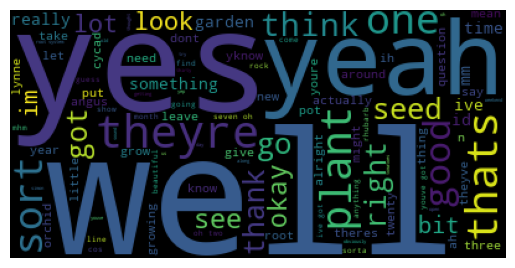

In [71]:
# visual representation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_words=100).generate(df['Text_Clean'][0])

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [66]:
# try again with 2nd text
text = df['Text_Clean'][1].split()
word_count = Counter(text)
word_count.most_common()[:100]

# paint, fridge, oil, floor, tool, deck, wood, house
# Sounds like house renovations to me

# So each text could have a different topic
# Find a better way than examining each text manually

[('yeah', 89),
 ('oh', 69),
 ('well', 65),
 ('yes', 55),
 ('thats', 55),
 ('got', 43),
 ('like', 43),
 ('one', 39),
 ('good', 37),
 ('im', 37),
 ('ih', 37),
 ('two', 34),
 ('go', 34),
 ('get', 34),
 ('paint', 33),
 ('would', 32),
 ('dont', 30),
 ('think', 28),
 ('right', 27),
 ('okay', 27),
 ('mm', 25),
 ('use', 25),
 ('fridge', 25),
 ('little', 24),
 ('know', 24),
 ('see', 23),
 ('old', 22),
 ('look', 21),
 ('yknow', 21),
 ('youre', 21),
 ('youve', 21),
 ('square', 21),
 ('id', 21),
 ('say', 21),
 ('c', 21),
 ('floor', 20),
 ('theres', 20),
 ('n', 20),
 ('alright', 19),
 ('thank', 19),
 ('used', 18),
 ('back', 18),
 ('isnt', 18),
 ('put', 18),
 ('oil', 18),
 ('thing', 17),
 ('b', 17),
 ('take', 17),
 ('something', 16),
 ('whole', 16),
 ('tool', 15),
 ('yep', 15),
 ('w', 15),
 ('much', 15),
 ('fine', 15),
 ('really', 15),
 ('actually', 14),
 ('want', 14),
 ('white', 14),
 ('deck', 14),
 ('wood', 13),
 ('top', 13),
 ('sort', 13),
 ('theyre', 13),
 ('time', 13),
 ('quite', 13),
 ('materi

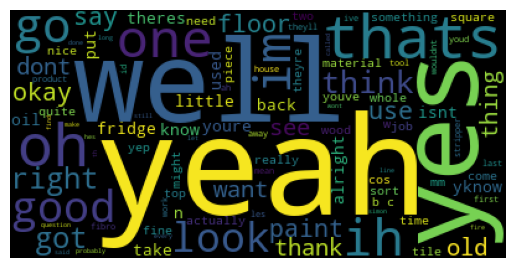

In [73]:
wordcloud = WordCloud(max_words=100).generate(df['Text_Clean'][1])

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [31]:
# Did not work very well, try bigrams